In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import h5py
from sklearn.model_selection import train_test_split

## Import Dataset

In [2]:
# hf = h5py.File('../input/mnist-synthetic/MNIST_synthetic.h5', 'r') # kaggle
# hf = h5py.File('/MNIST_synthetic.h5', 'r') # colab

from google.colab import drive
drive.mount('/content/drive')
hf = h5py.File('/content/drive/MyDrive/MNIST_synthetic.h5', 'r') # colab

digits_test_data = np.array(hf.get('test_dataset'))
digits_train_data = np.array(hf.get('train_dataset'))
digits_train_labels = np.array(hf.get('train_labels'))

Mounted at /content/drive


## Separate Digits

In [3]:
# Inspired from: https://stackoverflow.com/questions/63923800/drawing-bounding-rectangles-around-multiple-objects-in-binary-image-in-python

def separate_digits(instance, show=True):
    
    image = cv2.cvtColor(instance, cv2.COLOR_GRAY2BGR)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Deal with minimum dimensions
    kernel = np.ones((4, 1), np.uint8)
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    # threshold
    thresh = cv2.threshold(closing,30,255,cv2.THRESH_BINARY)[1]

    # get contours
    result = image.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    digits = []
    
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        y -= 2 # adjust for morph_close
        
        # specify minmum size of bounding box
        if (h > 6 or w > 4):
            # expand by 1 pixel all around
            x -= 1
            y -= 1
            w += 2
            h += 2
            
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 1)
            digits.append(tuple((x,y,w,h)))

    # show thresh and result
    if show:
        plt.imshow(result)
        
    # order digits by x coordinate
    digits = sorted(digits, key=lambda digit: digit[0])

    return np.array(digits, dtype=object)

In [4]:
def label_len(train_label):
    return np.count_nonzero(train_label != 10)

In [5]:
# Check which instances did not detect the correct amount of digits

for i in range(digits_train_data.shape[0]):
    instance = digits_train_data[i]
    digits = separate_digits(instance, show=False)
    if len(digits) != label_len(digits_train_labels[i]):
        print(i)

2684
13723
18127
18460
24786
26042
26421
32944
35422
40349
42009
44245


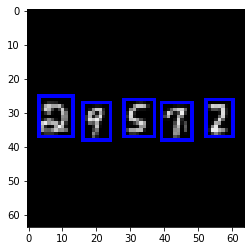

In [6]:
digit_dims = separate_digits(digits_train_data[123])

In [7]:
# extract digit from instance and pad with zeros
from skimage.feature import hog

def extract_digit(digit_dim, instance, size=12):
    x,y,w,h = digit_dim
    w = min(size, w)
    h = min(size, h)
    digit = instance[y:y+h, x:x+w]
    
    x_offset = int((size - w) / 2)
    y_offset = int((size - h) / 2)
    
    result = np.zeros((size, size, 1), dtype='uint8')
    result[y_offset:digit.shape[0]+y_offset,x_offset:digit.shape[1]+x_offset] = digit
    # HoG feature extraction
    # result = np.float32(result)
    # result = hog(result, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
    return result

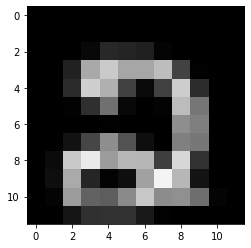

In [8]:
instance = digits_train_data[123]
digit_dims = separate_digits(instance)
digit = extract_digit(digit_dims[0], instance)

image = cv2.cvtColor(digit, cv2.COLOR_GRAY2BGR)
plt.imshow(image)

### Flatten Data

In [9]:
# Converts single instance from (64, 64, 1) -> flatten ? (k, 144) : (k, 12, 12) where k is the number of digits in the instance
def convert_instance(instance, flatten=False, size=12):
    digit_dims = separate_digits(instance, show=False)
    
    if flatten:
        result = np.zeros((len(digit_dims), size*size))
    else:
        result = np.zeros((len(digit_dims), size, size))
        
    for i in range(len(digit_dims)):
        digit = extract_digit(digit_dims[i], instance)
        if flatten:
            result[i] = np.array(digit.flatten())
        else:
            result[i] = digit[:,:,0]
    
    return result
        
# Returns array of converted instances as defined in convert_instance()
def convert_all_instances(data, flatten=False, size=12):
    result = []
    
    for instance in data:
        result.append(convert_instance(instance, flatten=flatten, size=size))
        
    return np.array(result)

In [10]:
# Converts every instance as above, except each digit is merged into a single list. So which digit belongs to
#      each instance is unkown. Used for training the neural network
def convert_dataset(train_data, train_labels, size=12, flatten=False):
    
    if flatten:
        result = np.zeros((train_data.shape[0]*5, size*size))
    else:
        result = np.zeros((train_data.shape[0]*5, size, size))
    
    result_labels = np.zeros(train_labels.shape[0]*5)
    
    result_i = 0
    for i in range(len(train_data)):
        instance = train_data[i]
        digit_dims = separate_digits(instance, show=False)
        
        # omit training examples that don't separate digits properly
        if len(digit_dims) == label_len(train_labels[i]):
            
            # Extract each detected digit from the instance
            for digit_i in range(len(digit_dims)):
                digit = extract_digit(digit_dims[digit_i], instance)
                
                if flatten:
                    result[result_i] = digit.flatten()
                else:
                    result[result_i] = digit[:,:,0]
                
                result_labels[result_i] = train_labels[i][digit_i]
                result_i += 1
                
    result = result[:result_i]
    result_labels = result_labels[:result_i]
    
    return result, result_labels

## Model Implementation

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

### Deep Neural Network Architecture

In [12]:
import torch.nn.functional as F


# deeper model adapted from https://www.kaggle.com/gustafsilva/cnn-digit-recognizer-pytorch
class Net(nn.Module):
    def __init__(self, with_ReLU=True, with_BatchNorm=True, with_MaxPool=True, with_Dropout=True):
        super(Net, self).__init__()

        self.with_ReLU = with_ReLU
        self.with_BatchNorm = with_BatchNorm
        self.with_MaxPool = with_MaxPool
        self.with_Dropout = with_Dropout

        if not with_BatchNorm:
          self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        else:
          self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1),
                                     nn.BatchNorm2d(32))
        if not with_BatchNorm:
          self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        else: 
          self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, padding=1),
                                     nn.BatchNorm2d(32))
        
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)

        if not with_BatchNorm:
          self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        else:
          self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                                     nn.BatchNorm2d(64))
        if not with_BatchNorm:
          self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        else:
          self.conv5 = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1),
                                     nn.BatchNorm2d(64))
          
        self.conv6 = nn.Conv2d(64, 64, 3, stride=2, padding=1)

        self.fc1 = nn.Linear(64, 120) if with_MaxPool else nn.Linear(576, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        def apply(x, with_ReLU=False, with_BatchNorm=None, with_MaxPool=None, with_Dropout=None):
            if with_ReLU:
                x = F.relu(x)
            if with_BatchNorm is not None:
                pass
            if with_MaxPool is not None:
                x = F.max_pool2d(x, with_MaxPool[0], with_MaxPool[1])
            if with_Dropout is not None:
                x = F.dropout(x, with_Dropout)
            return x
            

        # we don't do max pooling and dropout here, regardless
        x = apply(self.conv1(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=32 if self.with_BatchNorm else None,
                  with_MaxPool=None, with_Dropout=None)
                
        # we don't do max pooling and dropout here, regardless
        x = apply(self.conv2(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=32 if self.with_BatchNorm else None,
                  with_MaxPool=None, with_Dropout=None)
                
        # we do max pooling and dropout here, in 3rd convolution layer
        x = apply(self.conv3(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=32 if self.with_BatchNorm else None,
                  with_MaxPool=(2, 2) if self.with_MaxPool else None,
                  with_Dropout=0.25 if self.with_Dropout else None)
        
        # we don't do max pooling and dropout here, regardless
        x = apply(self.conv4(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=64 if self.with_BatchNorm else None,
                  with_MaxPool=None, with_Dropout=None)
        
        # we don't do max pooling and dropout here, regardless
        x = apply(self.conv5(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=64 if self.with_BatchNorm else None,
                  with_MaxPool=None, with_Dropout=None)
        
        # we do max pooling and dropout here, in 6th convolution layer
        x = apply(self.conv6(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=64 if self.with_BatchNorm else None,
                  with_MaxPool=(2, 2) if self.with_MaxPool else None,
                  with_Dropout=0.25 if self.with_Dropout else None)
        
        x = x.view(x.size(0), -1)

        # print('f1')
        # print(x.shape)

        x = apply(self.fc1(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=32 if self.with_BatchNorm else None,
                  with_MaxPool=None, with_Dropout=None)
        # print('f2')
        x = apply(self.fc2(x), with_ReLU=self.with_ReLU,
                  with_BatchNorm=32 if self.with_BatchNorm else None,
                  with_MaxPool=None, with_Dropout=None)
        # print('f3')
        # we don't do batch norm or relu here, regardless
        x = apply(self.fc3(x), with_ReLU=False, with_BatchNorm=None,
                  with_MaxPool=None, with_Dropout=None)
        
        x = F.log_softmax(x, dim=1)
        return x


### Format Data for PyTorch

In [13]:
class DigitsDataset(torch.utils.data.IterableDataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
        
    def __iter__(self):
        return iter(self.data)

### Prepare Data for Training & Testing of Individual Digits

In [14]:
def prepare_train_digits(X_train, y_train, batch_size=4):
    inputs, labels = convert_dataset(X_train, y_train)
    train_data = []
    for i in range(inputs.shape[0]):
        train_data.append([np.array([inputs[i]]), labels[i]])
        
    dataset = DigitsDataset(train_data)
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)
    
    return train_dataloader

def prepare_test_digits(X_test, y_test, batch_size=4):
    inputs, labels = convert_dataset(X_test, y_test)
    test_data = []
    for i in range(inputs.shape[0]):
        test_data.append([np.array([inputs[i]]), labels[i]])
        
    testset = DigitsDataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=1)
        
    return test_dataloader

### Train Model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
def train_network(model, train_loader, optimizer, criterion):
    running_loss = 0
    accuracy=0
    # change the network to training mode
    model.train()
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        # Forward pass, get our log-probabilities.
        log_ps = model(images.float())
        # Calculating probabilities for each class.
        ps = torch.exp(log_ps)     
        # Capturing the class more likely.          
        top_p, top_class = ps.topk(1, dim=1)
        top_p = top_p
        top_class = top_class
        # Verifying the prediction with the labels provided.
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        # Calculate the loss with the logps and the labels.
        loss = criterion(log_ps, labels)
        # Turning loss back (getting gradients w.r.t. parameters).
        loss.backward()
        # Updating parameters
        optimizer.step()
        
        running_loss += loss.item()
    
    # record training loss and error, then evaluate using validation data
    return running_loss/len(train_loader), accuracy/len(train_loader)

In [17]:
def validate_network(model, val_loader, criterion):
    val_loss = 0
    accuracy=0
    
    # Turn off gradients for validation, saves memory and computations.
    with torch.no_grad():
        model.eval()  # change the network to evaluation mode
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            # Forward pass, get our log-probabilities.
            log_ps = model(images.float())
            val_loss += criterion(log_ps, labels)
            # Calculating probabilities for each class.
            ps = torch.exp(log_ps)
            # Capturing the class more likely.
            top_p, top_class = ps.topk(1, dim=1)
            # Verifying the prediction with the labels provided.
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    return val_loss/len(val_loader), accuracy/len(val_loader)

In [27]:
# Training Time!
import time
import copy

def run_model(model, optimizer, criterion, epochs=10, batch_size=4, early_stop_counter=10, exp_lr_scheduler=None):

  # Some initialization work first...
  train_losses, val_losses = [], []
  train_accu, val_accu = [], []
  start_time = time.time()
  counter = 0
  best_val_loss = float('Inf')

  X_train, X_test, y_train, y_test = train_test_split(digits_train_data, digits_train_labels, train_size=0.8, random_state=1)

  # Train-Validation Split, for early stopping to avoid overfitting later on
  mask = np.random.rand(len(X_train)) < 0.8
  X_val, y_val = X_train[~mask], y_train[~mask]
  X_train, y_train = X_train[mask], y_train[mask]

  train_loader = prepare_train_digits(X_train, y_train, batch_size=batch_size)
  val_loader = prepare_train_digits(X_val, y_val, batch_size=batch_size)

  # for faster debug
  # train_loader.dataset.data = train_loader.dataset.data[:100]

  for e in range(epochs):

      epoch_start_time = time.time()

      # Train
      train_loss, train_accuracy = train_network(model, train_loader, optimizer, criterion)
      train_losses.append(train_loss)
      train_accu.append(train_accuracy)

      # Validate
      val_loss, val_accuracy = validate_network(model, val_loader, criterion)
      val_losses.append(val_loss)
      val_accu.append(val_accuracy)

      if exp_lr_scheduler is not None:
        exp_lr_scheduler.step()

      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Time: {:.2f}s..".format(time.time()-epoch_start_time),
            "Training Loss: {:.3f}.. ".format(train_losses[-1]),
            "Training Accu: {:.3f}.. ".format(train_accu[-1]),
            "Val Loss: {:.3f}.. ".format(val_losses[-1]),
            "Val Accu: {:.3f}".format(val_accu[-1]))
      
      if val_losses[-1] < best_val_loss:
          best_val_loss = val_losses[-1]
          counter=0
          best_model_wts = copy.deepcopy(model.state_dict())
      else:
          counter+=1
          print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
          if counter >= early_stop_counter:
              print('Early Stopping Now!!!!')
              model.load_state_dict(best_model_wts)
              break

  return train_losses, train_accu, val_losses, val_accu


In [19]:
# Viewing training information
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

def plot_performance(train_losses, val_losses, val_accu):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  fig.suptitle('Training and Validation Loss & Accuracy')
  ax1.plot(train_losses, label='Training Loss')
  ax1.plot(val_losses, label='Validation Loss')
  ax1.legend(frameon=False)
  ax2.plot(val_accu, label='Validation Accuracy')
  ax2.legend(frameon=False)


Epoch: 1/25..  Time: 181.71s.. Training Loss: 0.558..  Training Accu: 0.837..  Val Loss: 0.475..  Val Accu: 0.861
Epoch: 2/25..  Time: 182.04s.. Training Loss: 0.499..  Training Accu: 0.855..  Val Loss: 0.459..  Val Accu: 0.865
Epoch: 3/25..  Time: 182.45s.. Training Loss: 0.483..  Training Accu: 0.860..  Val Loss: 0.452..  Val Accu: 0.867
Epoch: 4/25..  Time: 181.26s.. Training Loss: 0.473..  Training Accu: 0.863..  Val Loss: 0.448..  Val Accu: 0.868
Epoch: 5/25..  Time: 181.56s.. Training Loss: 0.466..  Training Accu: 0.865..  Val Loss: 0.445..  Val Accu: 0.870
Epoch: 6/25..  Time: 180.40s.. Training Loss: 0.461..  Training Accu: 0.867..  Val Loss: 0.442..  Val Accu: 0.871
Epoch: 7/25..  Time: 181.34s.. Training Loss: 0.457..  Training Accu: 0.868..  Val Loss: 0.440..  Val Accu: 0.871
Epoch: 8/25..  Time: 178.62s.. Training Loss: 0.454..  Training Accu: 0.869..  Val Loss: 0.439..  Val Accu: 0.872
Epoch: 9/25..  Time: 178.73s.. Training Loss: 0.451..  Training Accu: 0.870..  Val Loss:

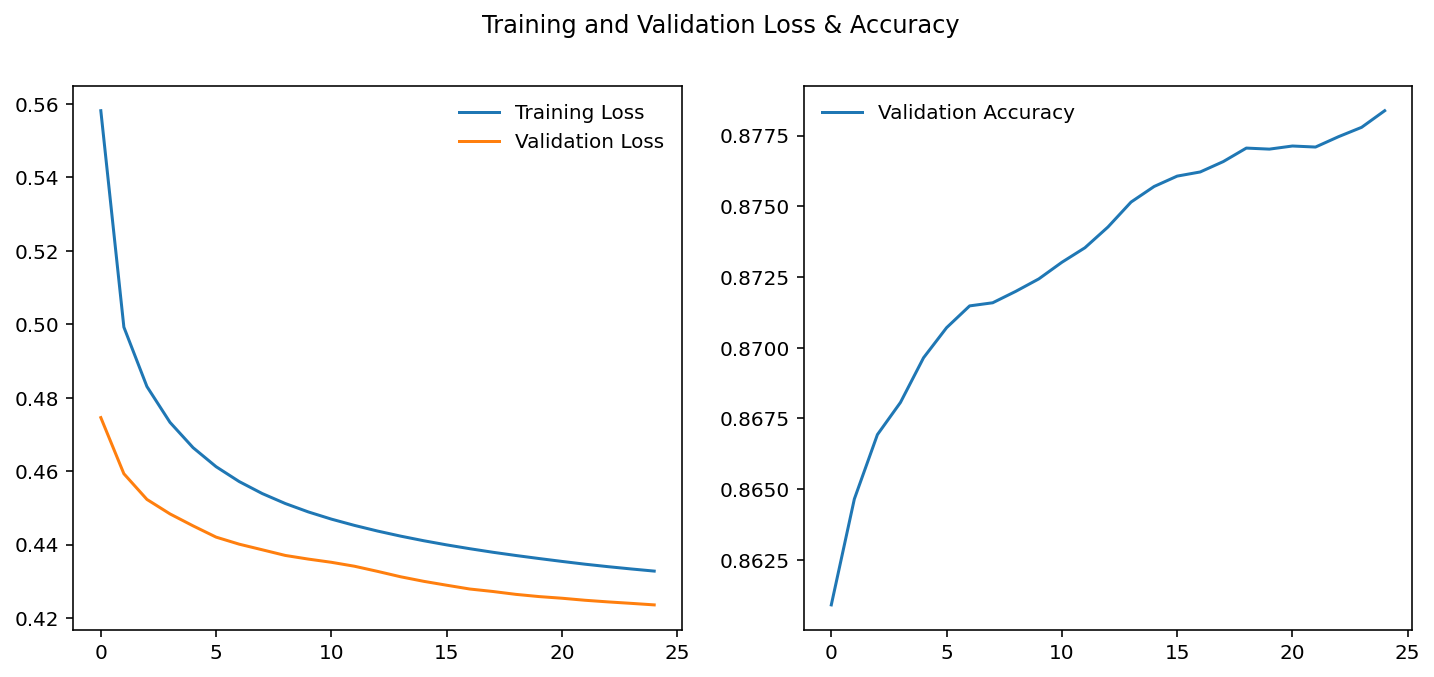

In [ ]:
# Base Model, only convolutional layers
model = Net(with_ReLU=False, with_BatchNorm=False, with_MaxPool=False, with_Dropout=False).float()
model.to(device)
criterion = nn.NLLLoss().to(device)   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses, train_accu, val_losses, val_accu = run_model(model, optimizer, criterion, epochs=25, batch_size=4, early_stop_counter=5)
plot_performance(train_losses, val_losses, val_accu)
torch.save(model.state_dict(), '/content/model_all_false.pt')

Epoch: 1/50..  Time: 190.90s.. Training Loss: 0.149..  Training Accu: 0.954..  Val Loss: 0.050..  Val Accu: 0.985
Epoch: 2/50..  Time: 190.30s.. Training Loss: 0.045..  Training Accu: 0.986..  Val Loss: 0.030..  Val Accu: 0.992
Epoch: 3/50..  Time: 195.43s.. Training Loss: 0.027..  Training Accu: 0.992..  Val Loss: 0.026..  Val Accu: 0.994
Epoch: 4/50..  Time: 194.60s.. Training Loss: 0.020..  Training Accu: 0.994..  Val Loss: 0.031..  Val Accu: 0.992
Validation loss has not improved since: 0.026.. Count:  1
Epoch: 5/50..  Time: 194.58s.. Training Loss: 0.016..  Training Accu: 0.995..  Val Loss: 0.039..  Val Accu: 0.990
Validation loss has not improved since: 0.026.. Count:  2
Epoch: 6/50..  Time: 194.76s.. Training Loss: 0.013..  Training Accu: 0.996..  Val Loss: 0.019..  Val Accu: 0.995
Epoch: 7/50..  Time: 194.90s.. Training Loss: 0.012..  Training Accu: 0.996..  Val Loss: 0.030..  Val Accu: 0.994
Validation loss has not improved since: 0.019.. Count:  1
Epoch: 8/50..  Time: 194.98s

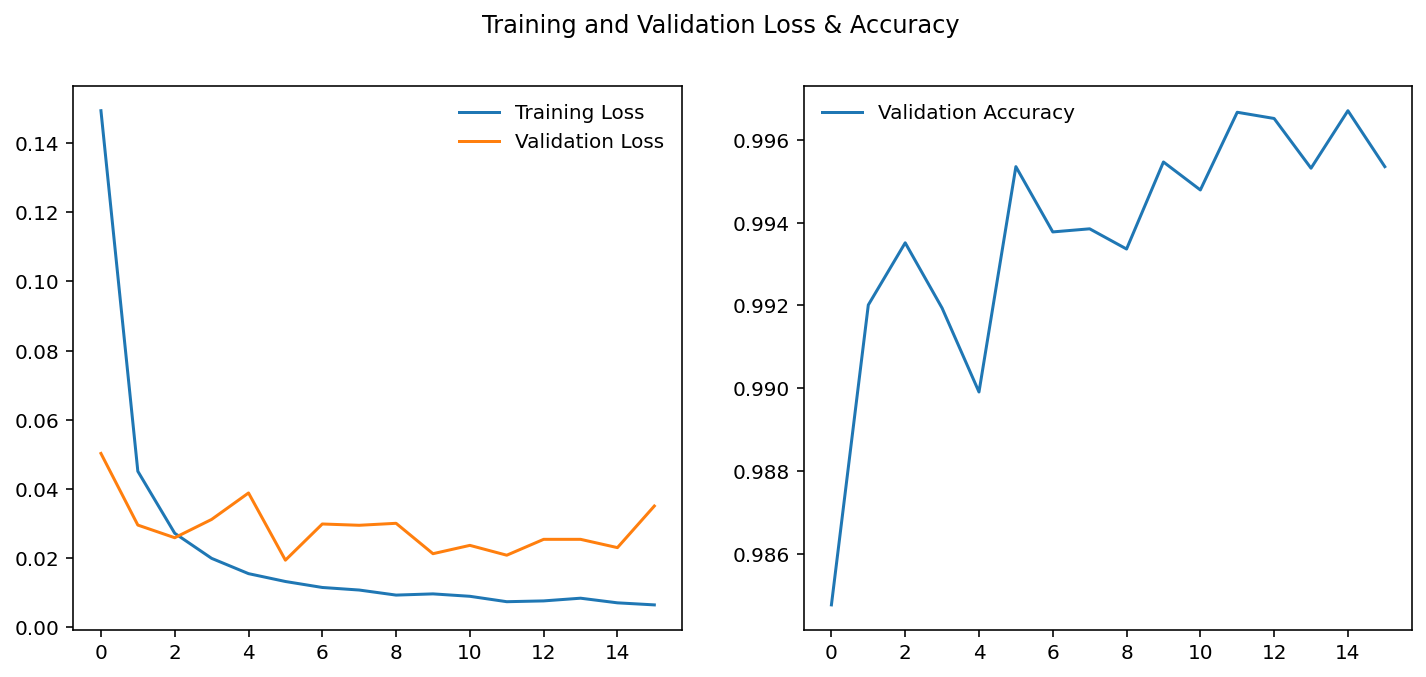

In [ ]:
# Model adding ReLU to all layers
model = Net(with_ReLU=True, with_BatchNorm=False, with_MaxPool=False, with_Dropout=False).float()
model.to(device)
criterion = nn.NLLLoss().to(device)   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses, train_accu, val_losses, val_accu = run_model(model, optimizer, criterion, epochs=50, batch_size=4, early_stop_counter=10)
plot_performance(train_losses, val_losses, val_accu)
torch.save(model.state_dict(), '/content/model_relu.pt')

Epoch: 1/50..  Time: 244.72s.. Training Loss: 0.120..  Training Accu: 0.963..  Val Loss: 0.090..  Val Accu: 0.971
Epoch: 2/50..  Time: 247.48s.. Training Loss: 0.039..  Training Accu: 0.988..  Val Loss: 0.032..  Val Accu: 0.990
Epoch: 3/50..  Time: 247.86s.. Training Loss: 0.025..  Training Accu: 0.992..  Val Loss: 0.029..  Val Accu: 0.991
Epoch: 4/50..  Time: 246.30s.. Training Loss: 0.019..  Training Accu: 0.994..  Val Loss: 0.018..  Val Accu: 0.995
Epoch: 5/50..  Time: 244.20s.. Training Loss: 0.015..  Training Accu: 0.995..  Val Loss: 0.018..  Val Accu: 0.995
Validation loss has not improved since: 0.018.. Count:  1
Epoch: 6/50..  Time: 245.05s.. Training Loss: 0.012..  Training Accu: 0.996..  Val Loss: 0.018..  Val Accu: 0.995
Epoch: 7/50..  Time: 244.19s.. Training Loss: 0.010..  Training Accu: 0.997..  Val Loss: 0.025..  Val Accu: 0.994
Validation loss has not improved since: 0.018.. Count:  1
Epoch: 8/50..  Time: 244.23s.. Training Loss: 0.009..  Training Accu: 0.997..  Val Los

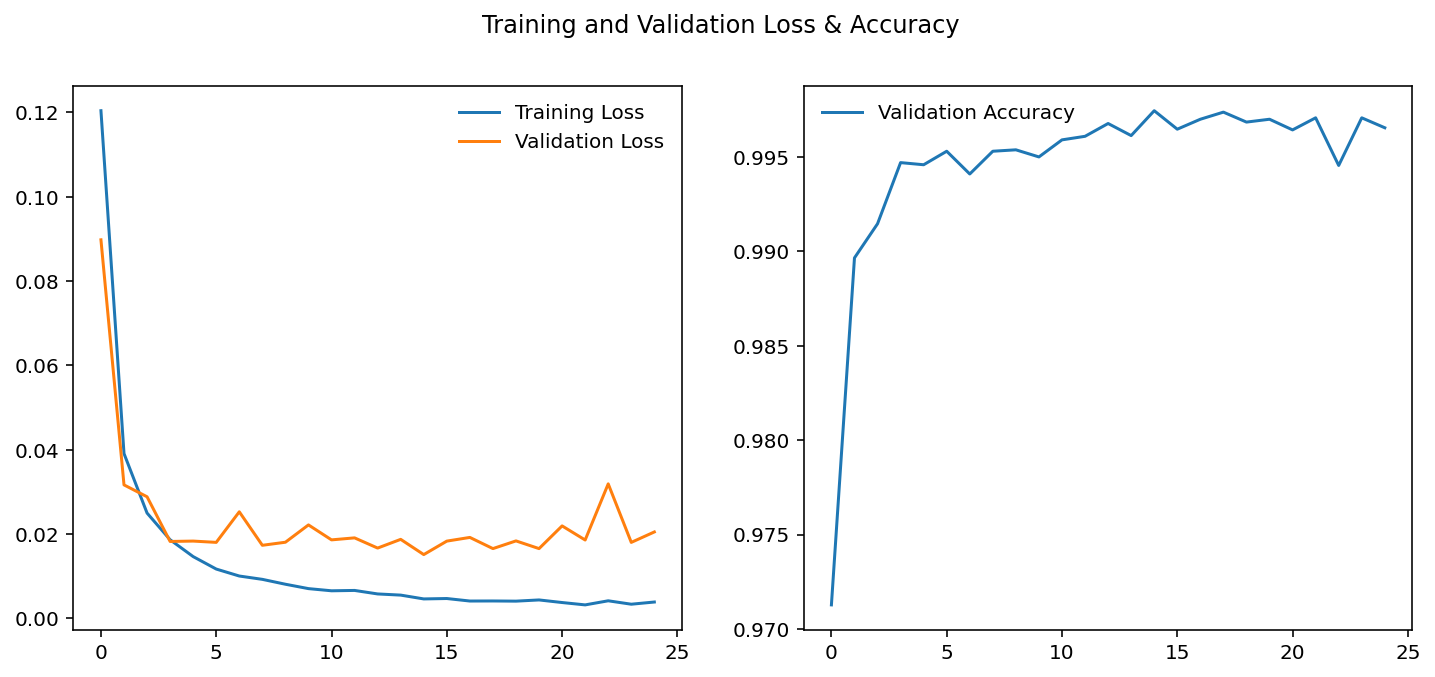

In [ ]:
# Model adding ReLU to all layers, and Batch Normalization after
model = Net(with_ReLU=True, with_BatchNorm=True, with_MaxPool=False, with_Dropout=False).float()
model.to(device)
criterion = nn.NLLLoss().to(device)   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses, train_accu, val_losses, val_accu = run_model(model, optimizer, criterion, epochs=50, batch_size=4, early_stop_counter=10)
plot_performance(train_losses, val_losses, val_accu)
torch.save(model.state_dict(), '/content/model_3.pt')

Epoch: 1/50..  Time: 336.11s.. Training Loss: 0.155..  Training Accu: 0.953..  Val Loss: 0.054..  Val Accu: 0.983
Epoch: 2/50..  Time: 330.65s.. Training Loss: 0.049..  Training Accu: 0.985..  Val Loss: 0.042..  Val Accu: 0.986
Epoch: 3/50..  Time: 330.84s.. Training Loss: 0.032..  Training Accu: 0.990..  Val Loss: 0.034..  Val Accu: 0.990
Epoch: 4/50..  Time: 329.57s.. Training Loss: 0.023..  Training Accu: 0.992..  Val Loss: 0.027..  Val Accu: 0.992
Epoch: 5/50..  Time: 330.41s.. Training Loss: 0.019..  Training Accu: 0.994..  Val Loss: 0.023..  Val Accu: 0.994
Epoch: 6/50..  Time: 341.52s.. Training Loss: 0.016..  Training Accu: 0.995..  Val Loss: 0.027..  Val Accu: 0.993
Validation loss has not improved since: 0.023.. Count:  1
Epoch: 7/50..  Time: 342.13s.. Training Loss: 0.014..  Training Accu: 0.996..  Val Loss: 0.018..  Val Accu: 0.995
Epoch: 8/50..  Time: 340.18s.. Training Loss: 0.012..  Training Accu: 0.996..  Val Loss: 0.020..  Val Accu: 0.995
Validation loss has not improv

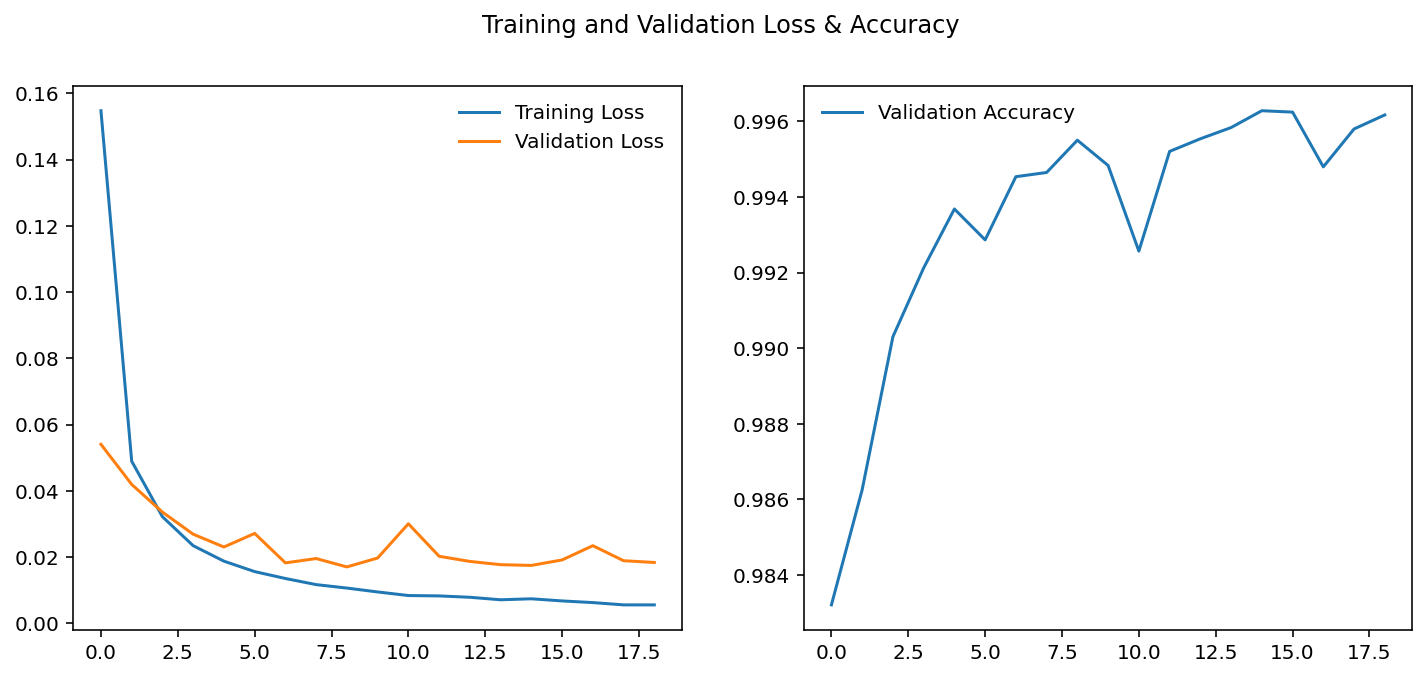

In [ ]:
# Model adding ReLU and Batch Normalization to all layers, and add a Max Pooling layer 
model = Net(with_ReLU=True, with_BatchNorm=True, with_MaxPool=True, with_Dropout=False).float()
model.to(device)
criterion = nn.NLLLoss().to(device)   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses, train_accu, val_losses, val_accu = run_model(model, optimizer, criterion, epochs=50, batch_size=4, early_stop_counter=10)
plot_performance(train_losses, val_losses, val_accu)
torch.save(model.state_dict(), '/content/model_4.pt')

Epoch: 1/25..  Time: 245.11s.. Training Loss: 0.264..  Training Accu: 0.920..  Val Loss: 0.108..  Val Accu: 0.967
Epoch: 2/25..  Time: 246.05s.. Training Loss: 0.104..  Training Accu: 0.970..  Val Loss: 0.081..  Val Accu: 0.976
Epoch: 3/25..  Time: 243.83s.. Training Loss: 0.078..  Training Accu: 0.977..  Val Loss: 0.064..  Val Accu: 0.981
Epoch: 4/25..  Time: 243.83s.. Training Loss: 0.064..  Training Accu: 0.981..  Val Loss: 0.058..  Val Accu: 0.984
Epoch: 5/25..  Time: 243.79s.. Training Loss: 0.055..  Training Accu: 0.983..  Val Loss: 0.054..  Val Accu: 0.984
Epoch: 6/25..  Time: 242.52s.. Training Loss: 0.049..  Training Accu: 0.985..  Val Loss: 0.052..  Val Accu: 0.985
Epoch: 7/25..  Time: 243.28s.. Training Loss: 0.044..  Training Accu: 0.987..  Val Loss: 0.052..  Val Accu: 0.986
Validation loss has not improved since: 0.052.. Count:  1
Epoch: 8/25..  Time: 244.05s.. Training Loss: 0.040..  Training Accu: 0.988..  Val Loss: 0.052..  Val Accu: 0.984
Validation loss has not improv

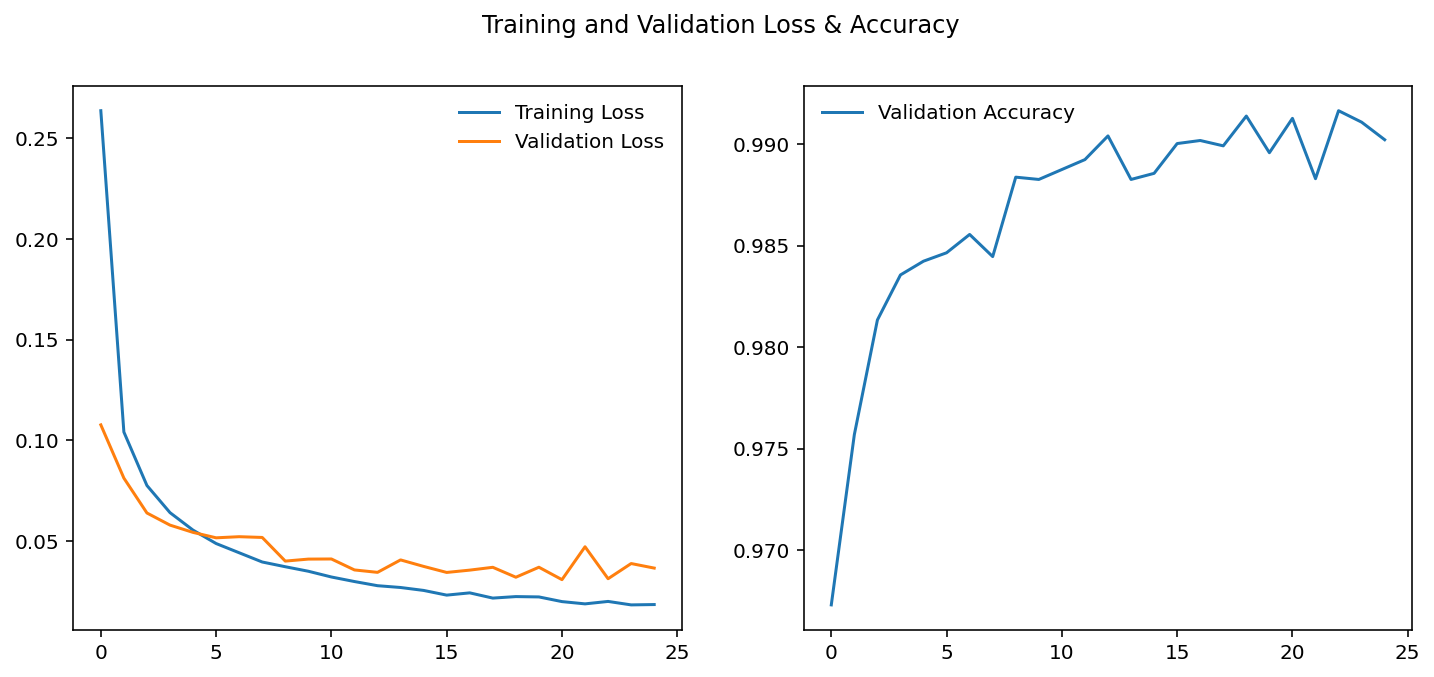

In [34]:
# Model adding ReLU and Batch Normalization to all layers, and add a Max Pooling layer, and Dropout
model = Net(with_ReLU=True, with_BatchNorm=True, with_MaxPool=True, with_Dropout=True).float()
model.to(device)
criterion = nn.NLLLoss().to(device)   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses, train_accu, val_losses, val_accu = run_model(model, optimizer, criterion, epochs=25, batch_size=4, early_stop_counter=5)
plot_performance(train_losses, val_losses, val_accu)
torch.save(model.state_dict(), '/content/model_all_true.pt')

In [28]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)  # or stride=2

model = MNISTResNet()
model.to(device)
print(model)

MNISTResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

Epoch: 1/25..  Time: 56.83s.. Training Loss: 0.131..  Training Accu: 0.960..  Val Loss: 0.061..  Val Accu: 0.981
Epoch: 2/25..  Time: 56.40s.. Training Loss: 0.054..  Training Accu: 0.983..  Val Loss: 0.041..  Val Accu: 0.987
Epoch: 3/25..  Time: 56.46s.. Training Loss: 0.040..  Training Accu: 0.988..  Val Loss: 0.037..  Val Accu: 0.988
Epoch: 4/25..  Time: 56.43s.. Training Loss: 0.033..  Training Accu: 0.990..  Val Loss: 0.044..  Val Accu: 0.986
Validation loss has not improved since: 0.037.. Count:  1
Epoch: 5/25..  Time: 56.47s.. Training Loss: 0.026..  Training Accu: 0.992..  Val Loss: 0.031..  Val Accu: 0.991
Epoch: 6/25..  Time: 56.47s.. Training Loss: 0.022..  Training Accu: 0.993..  Val Loss: 0.023..  Val Accu: 0.994
Epoch: 7/25..  Time: 56.51s.. Training Loss: 0.018..  Training Accu: 0.994..  Val Loss: 0.026..  Val Accu: 0.993
Validation loss has not improved since: 0.023.. Count:  1
Epoch: 8/25..  Time: 56.48s.. Training Loss: 0.014..  Training Accu: 0.996..  Val Loss: 0.018

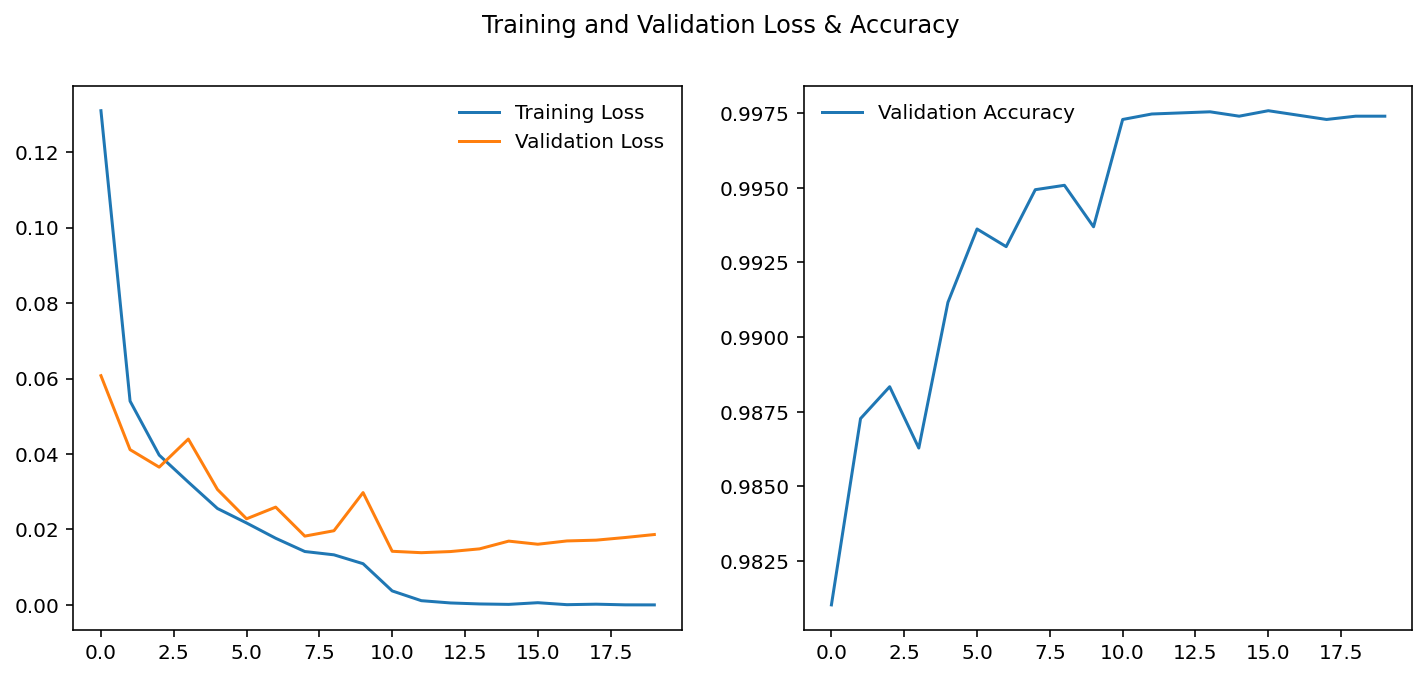

In [29]:
step_size = 10
base_lr = 0.0001
batch_size = 64
epochs = 25
early_stop_counter = 8

optimizer = optim.Adam(model.parameters(), lr=base_lr)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

train_losses, train_accu, val_losses, val_accu = run_model(model, optimizer, criterion, epochs=epochs, batch_size=batch_size, early_stop_counter=early_stop_counter, exp_lr_scheduler=exp_lr_scheduler)
plot_performance(train_losses, val_losses, val_accu)
torch.save(model.state_dict(), '/content/ResNet_model_1.pt')

In [30]:
model.load_state_dict(torch.load('/content/ResNet_model_1.pt'))

<All keys matched successfully>

In [32]:
# Test network on individual digits
def test_network_digits(net, test_dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images.to(device)
            labels.to(device)
            outputs = net(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print('Accuracy of the network on the %d test digits: %d %%' % (total, accuracy))
    return accuracy

def test_network_full_instances(net, X_test, y_test):
    test_data = convert_all_instances(X_test)
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(test_data.shape[0]):
            wrapped_test_data = []
            for dig in test_data[i]:
                wrapped_test_data.append(np.array([dig]))
            
            digits = torch.from_numpy(np.array(wrapped_test_data))
            
            outputs = net(digits.float())
            _, predicted = torch.max(outputs.data, 1)
            y_predicted = np.pad(predicted, (0,5-len(predicted)), 'constant', constant_values=(0,10))
            
            total += 1
            correct += 1 if (y_predicted == y_test[i]).sum().item() == 5 else 0
            
    accuracy = 100.0 * correct / total
    print('Accuracy of the network on the %d test instances: %d %%' % (len(test_data), accuracy))
    return accuracy

def predict_instances(net, instances):
    test_data = convert_all_instances(instances)
    
    f = open("./output.csv", "w+")
    f.write("Id,Label\n")
    
    
    with torch.no_grad():
        for i in range(test_data.shape[0]):
            wrapped_test_data = []
            for dig in test_data[i]:
                wrapped_test_data.append(np.array([dig]))
            
            digits = torch.from_numpy(np.array(wrapped_test_data))
            digits = digits.to(device)
            
            outputs = net(digits.float())
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            y_predicted = np.pad(predicted, (0,5-len(predicted[:5])), 'constant', constant_values=(0,10))

            f.write(str(i)+","+str(y_predicted[0])+str(y_predicted[1])+str(y_predicted[2])+str(y_predicted[3])+str(y_predicted[4])+"\n")
    f.close()
    print('Completed')

In [25]:
predict_instances(model, digits_test_data)

Completed


In [ ]:
# the_model.load_state_dict(torch.load('/content/model.pt'))